In [1]:
from transformers import AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

MODEL_PATH = "/home/zhanghaoyu/models/Llama-3.1-8B-Instruct/"
DEVICE = torch.device("cuda:1")
DTYPE = torch.float16
torch.set_default_dtype(DTYPE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

method = "hf"
token_budget = 1024
topp = None

if method == "quest":
  from quest import LlamaForCausalLM
  model = LlamaForCausalLM.from_pretrained(MODEL_PATH, device_map=DEVICE, torch_dtype=DTYPE, output_attentions=True)

  # Init Quest Controller
  model.quest_init(page_size=16, max_seq_len=8192, token_budget=token_budget, topp=topp)
else:
  from transformers import LlamaForCausalLM
  model = LlamaForCausalLM.from_pretrained(MODEL_PATH, device_map=DEVICE, torch_dtype=DTYPE, output_attentions=True)
  

/share/zhanghaoyu-nfs/anaconda3/envs/quest/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/share/zhanghaoyu-nfs/anaconda3/envs/quest/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


In [12]:
prompt = "In an animal kingdom, the lion is the king. One day, the lion announces a competition to choose the most hardworking animal. The turtle, rabbit, monkey, zebra, and giraffe all decide to participate. After a day of observation, the lion notices that all the animals are working hard, except for the rabbit, who is sleeping. So why does the lion choose the rabbit as the most hardworking animal?"
inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
print(f"Input Sequence Length: {inputs.input_ids.shape[1]}")

outputs = model.generate(
  **inputs,
  max_new_tokens=32,
  output_attentions=True,
  return_dict_in_generate=True
)

output_ids = outputs.sequences
attentions = outputs.attentions # (output_tokens, batch_size, num_heads, sequence_length, sequence_length)
all_tokens = tokenizer.convert_ids_to_tokens(output_ids[0])
all_tokens = [token.replace("Ġ", "") for token in all_tokens]
print(f"Generated Sequence Length: {len(all_tokens)}")
print(tokenizer.batch_decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0])


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Input Sequence Length: 87
Generated Sequence Length: 119
In an animal kingdom, the lion is the king. One day, the lion announces a competition to choose the most hardworking animal. The turtle, rabbit, monkey, zebra, and giraffe all decide to participate. After a day of observation, the lion notices that all the animals are working hard, except for the rabbit, who is sleeping. So why does the lion choose the rabbit as the most hardworking animal? What is the lion's reasoning?
The lion observes that the rabbit is the only animal that works continuously without resting. The rabbit sleeps during the day, but works


Prompt length: 87
Prefill attention shape: torch.Size([87, 87])
Decoding attention shape: torch.Size([1, 88])


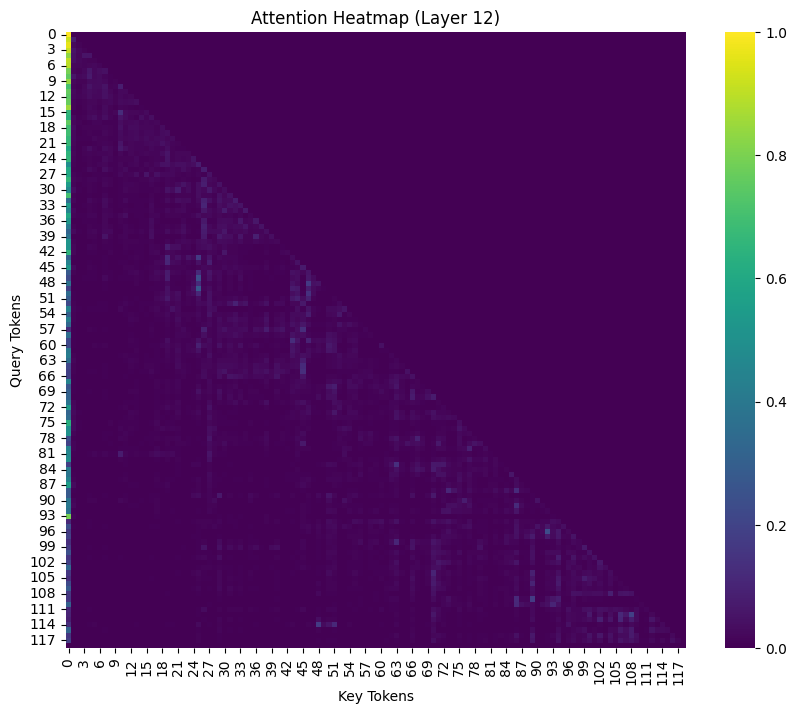

In [40]:
# plot full attention of one layer and one head
def plot_attention_heatmap(attentions, layer_idx, head_idx, tokens):
  prompt_length = attentions[0][layer_idx][0, head_idx].shape[0]
  print(f"Prompt length: {prompt_length}")
  print(f"Prefill attention shape: {attentions[0][layer_idx][0, head_idx].shape}") # [token_length, layer_num, batch_size, head_num, seq_len, seq_len]
  print(f"Decoding attention shape: {attentions[1][layer_idx][0, head_idx].shape}") # [token_length, layer_num, batch_size, head_num, 1, seq_len]
  attention_matric = np.zeros((len(tokens), len(tokens)))
  attention_matric[:attentions[0][layer_idx][0, head_idx].shape[0], :attentions[0][layer_idx][0, head_idx].shape[0]] = attentions[0][layer_idx][0, head_idx].detach().cpu().numpy()
  for i in range(1, len(attentions)):
    current_seq_len = prompt_length + i
    attention_matric[prompt_length + i - 1, :current_seq_len] = attentions[i][layer_idx][0, head_idx].detach().cpu().numpy()
  plt.figure(figsize=(10, 8))
  sns.heatmap(attention_matric, cmap="viridis")
  plt.xlabel("Key Tokens")
  plt.ylabel("Query Tokens")
  # plt.title(f"Attention Heatmap (Layer {layer_idx}, Head {head_idx})")
  plt.title(f"Attention Heatmap (Layer {layer_idx})")
  # Save the figure as a high-resolution svg file
  plt.savefig(f"attention_heatmap_layer_{layer_idx}_head_{head_idx}.svg", format='svg', dpi=300)
  plt.show()
  plt.close()

prompt_length = attentions[0][0][0, 0].shape[0]
token_length = 128
plot_attention_heatmap(attentions[:token_length], layer_idx=12, head_idx=10, tokens=all_tokens[:token_length+prompt_length])


Prompt length: 1659
Prefill attention shape: torch.Size([1659, 1659])
Decoding attention shape: torch.Size([1, 1680])


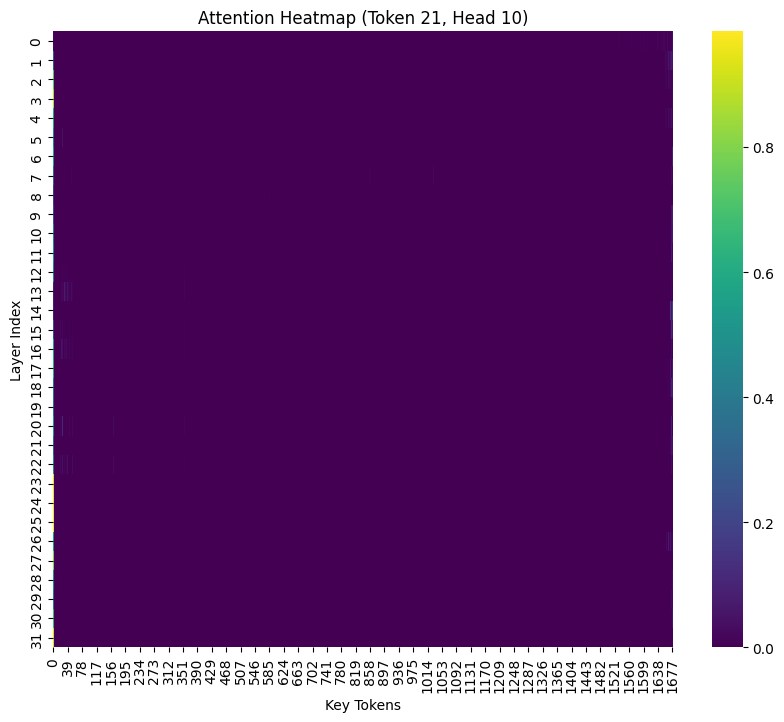

In [5]:
# plot attention of all layers for one head and one token
def plot_attention_heatmap_token(attentions, token_idx, head_idx, tokens):
    prompt_length = attentions[0][0][0, head_idx].shape[0]
    assert token_idx > 0 and token_idx < len(attentions), "token_idx should be in the range of 1 to len(attentions)-1"
    print(f"Prompt length: {prompt_length}")
    print(f"Prefill attention shape: {attentions[0][0][0, head_idx].shape}") # [token_length, layer_num, batch_size, head_num, seq_len, seq_len]
    print(f"Decoding attention shape: {attentions[token_idx][0][0, head_idx].shape}") # [token_length, layer_num, batch_size, head_num, 1, seq_len]
    attention_matric = np.zeros((len(attentions[token_idx]), prompt_length + token_idx))
    for i in range(len(attentions[token_idx])):
        attention_matric[i, :] = attentions[token_idx][i][0, head_idx].detach().cpu().numpy()
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matric, cmap="viridis")
    plt.xlabel("Key Tokens")
    plt.ylabel("Layer Index")
    plt.title(f"Attention Heatmap (Token {token_idx}, Head {head_idx})")
    plt.show()

plot_attention_heatmap_token(attentions, token_idx=21, head_idx=10, tokens=all_tokens)


Prompt length: 1659
Prefill attention shape: torch.Size([1659, 1659])
Decoding attention shape: torch.Size([1, 1660])


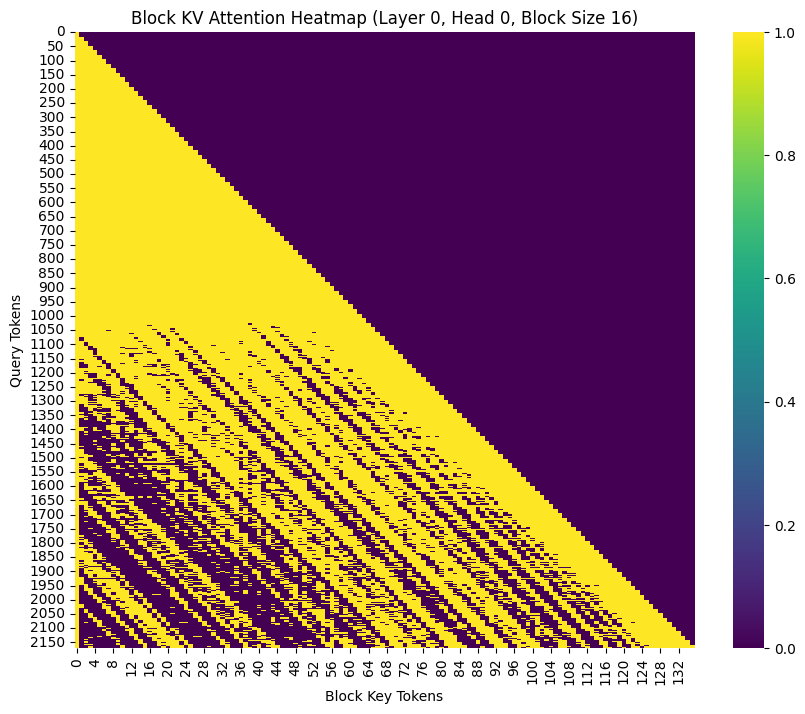

In [6]:
# plot full attention of one layer and one head, using kv pages
from math import ceil
def plot_attention_heatmap_kvblock(attentions, layer_idx, head_idx, tokens, block_size=16):
    prompt_length = attentions[0][layer_idx][0, head_idx].shape[0]
    topk = token_budget // block_size
    print(f"Prompt length: {prompt_length}")
    print(f"Prefill attention shape: {attentions[0][layer_idx][0, head_idx].shape}") # [token_length, layer_num, batch_size, head_num, seq_len, seq_len]
    print(f"Decoding attention shape: {attentions[1][layer_idx][0, head_idx].shape}") # [token_length, layer_num, batch_size, head_num, 1, seq_len]
    attention_matric = np.zeros((len(tokens), len(tokens)))
    attention_matric[:attentions[0][layer_idx][0, head_idx].shape[0], :attentions[0][layer_idx][0, head_idx].shape[0]] = attentions[0][layer_idx][0, head_idx].detach().cpu().numpy()
    for i in range(1, len(attentions)):
        current_seq_len = prompt_length + i
        attention_matric[prompt_length + i - 1, :current_seq_len] = attentions[i][layer_idx][0, head_idx].detach().cpu().numpy()
    block_num = ceil(attention_matric.shape[1] / block_size)
    attention_matric_kvblock = np.zeros((len(tokens), block_num))
    for i in range(len(tokens)):
        for j in range(ceil((i + 1) / block_size)):
            attention_matric_kvblock[i, j] = np.sum(attention_matric[i, j*block_size:(j+1)*block_size])
    # find top k indices
    top_k_indices = np.argsort(attention_matric_kvblock, axis=1)[:, -topk:]
    # create a new matrix with the top k indices
    attention_matric_kvblock = np.zeros((len(tokens), block_num))
    for i in range(len(tokens)):
        for j in range(topk):
            if top_k_indices[i, j] < ceil((i + 1) / block_size):
                attention_matric_kvblock[i, top_k_indices[i, j]] = 1
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matric_kvblock, cmap="viridis")
    plt.xlabel("Block Key Tokens")
    plt.ylabel("Query Tokens")
    plt.title(f"Block KV Attention Heatmap (Layer {layer_idx}, Head {head_idx}, Block Size {block_size})")
    plt.show()

prompt_length = attentions[0][0][0, 0].shape[0]
token_length = 2048
plot_attention_heatmap_kvblock(attentions[:token_length], layer_idx=0, head_idx=0, tokens=all_tokens[:token_length+prompt_length], block_size=16)


Prompt length: 1659
Prefill attention shape: torch.Size([1659, 1659])
Decoding attention shape: torch.Size([1, 1680])


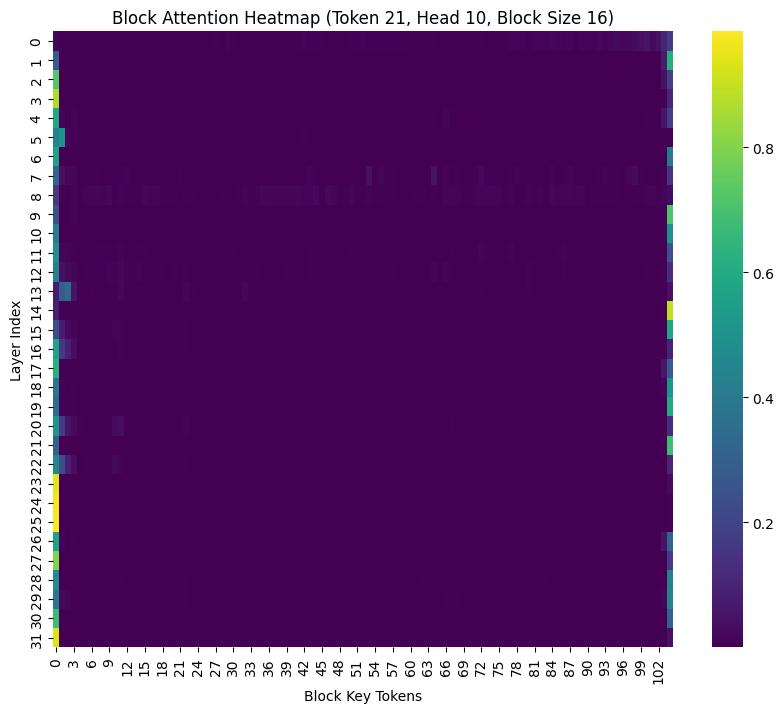

In [8]:
# plot attention of all layers for one head and one token, using kv pages
from math import ceil
def plot_attention_heatmap_token_kvblock(attentions, token_idx, head_idx, tokens, block_size=16):
    prompt_length = attentions[0][0][0, head_idx].shape[0]
    assert token_idx > 0 and token_idx < len(attentions), "token_idx should be in the range of 1 to len(attentions)-1"
    print(f"Prompt length: {prompt_length}")
    print(f"Prefill attention shape: {attentions[0][0][0, head_idx].shape}") # [token_length, layer_num, batch_size, head_num, seq_len, seq_len]
    print(f"Decoding attention shape: {attentions[token_idx][0][0, head_idx].shape}") # [token_length, layer_num, batch_size, head_num, 1, seq_len]
    attention_matric = np.zeros((len(attentions[token_idx]), prompt_length + token_idx))
    for i in range(len(attentions[token_idx])):
        attention_matric[i, :] = attentions[token_idx][i][0, head_idx].detach().cpu().numpy()
    block_num = ceil(attention_matric.shape[1] / block_size)
    attention_matric_kvblock = np.zeros((len(attentions[token_idx]), block_num))
    for i in range(len(attentions[token_idx])):
        for j in range(block_num):
            attention_matric_kvblock[i, j] = np.sum(attention_matric[i, j*block_size:(j+1)*block_size])
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matric_kvblock, cmap="viridis")
    plt.xlabel("Block Key Tokens")
    plt.ylabel("Layer Index")
    plt.title(f"Block Attention Heatmap (Token {token_idx}, Head {head_idx}, Block Size {block_size})")
    plt.show()

plot_attention_heatmap_token_kvblock(attentions, token_idx=21, head_idx=10, tokens=all_tokens, block_size=16)